In [1]:
import sys
import os

repository_root_directory = os.path.dirname(os.getcwd())
rrd = "repository_root_directory:\t"
print(rrd, repository_root_directory)

if repository_root_directory not in sys.path:
    sys.path.append(repository_root_directory)
    print(rrd, "added to path")
else:  
    print(rrd, "already in path")


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


repository_root_directory:	 /teamspace/studios/this_studio/csc_461_fp
repository_root_directory:	 added to path


In [2]:
'''
This class Inherits from nn.Module, the base class for all neural networks in PyTorch.
'''
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_layers, dropout_rate):
        """
        Initializes the Multilayer Perceptron (MLP) network.

        Args:
            in_dim (int): Input dimension - number of features in the input data.
            out_dim (int): Output dimension - number of output neurons.
            hid_layers (list): List of integers specifying the number of neurons in each hidden layer.
        """
        super(MLP, self).__init__()                                             # Calling the constructor of nn.Module to properly initialize the model by inheriting the good stuff

        neural_network = []                                                     # we start with an empty neural network with zero layers
        current_dim = in_dim                                                    # the number of neurons of each layers - initially set to in_dim

        # Add batch normalization for the input layer
        neural_network.append(nn.BatchNorm1d(current_dim))

        # Sequentially Adding hidden layers with ReLU activation to the neural network
        for h_dim in hid_layers:
            # Assume v is the vector representing the previous layer
            v_transformed = nn.Linear(current_dim, h_dim)                       # applying a linear transformation and storing the transformed vector v
            neural_network.append(nn.BatchNorm1d(h_dim))  # Add batch normalization
            v_transformed_normalized = nn.ReLU()                                # applying the Rectified Linear Unit function to the vector v_transformed to normalize it
            neural_network.append(v_transformed)                                # adding v_transformed to the neural network
            neural_network.append(v_transformed_normalized)                     # adding v_transformed_normalized to the neural network
            neural_network.append(nn.Dropout(dropout_rate))
            current_dim = h_dim                                                 # updating current_dim to reflect the current layer being processed

        # Add the output layer (linear activation)                              # no non-linear activation function applied
        output_vector = nn.Linear(current_dim, out_dim)                         # applying a linear transformation to get the output vector
        neural_network.append(output_vector)                                    # adding the non-normalized vector to the neural network

        self.network = nn.Sequential(*neural_network)                           # Create the sequential neural network model


    def forward(self, x):
        """
        Performs the forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor (mini-batch).

        Returns:
            torch.Tensor: Output of the network - the predicted output vectors of the model.
        """
        #x = x.view(x.size(0), -1)  # Flatten the input tensor
        return self.network(x)

In [3]:
def test(model, criterion, loader, device):
    """
    Evaluates a trained MLP model using mini-batches.

    Args:
        model (nn.Module): Trained model to evaluate.
        criterion (nn.Module): Loss function.
        loader (torch.utils.data.DataLoader): Data loader for test data.
        device (torch.device): Device where the model is stored (e.g., CPU or GPU).

    Returns:
        float: Average loss over the dataset.
        float: Average accuracy over the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in loader:
            # Move data to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / total
    avg_accuracy = correct / total

    return avg_loss, avg_accuracy

In [4]:
def train(model, criterion, optimizer, tr_loader, va_loader, n_epochs, device, scheduler=None):
    """
    Trains the MLP using mini-batches and evaluates on validation data.

    Args:
        model: The MLP model to train.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        tr_loader: Training data loader.
        va_loader: Validation data loader.
        n_epochs: Number of epochs to train.
        device: Device where the model should be trained.

    Returns:
        train_losses: List of training losses per epoch.
        train_accuracies: List of training accuracies per epoch.
        val_losses: List of validation losses per epoch.
        val_accuracies: List of validation accuracies per epoch.
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Move the model to the specified device
    model.to(device)

    # Early stopping parameters
    # best_val_loss = float('inf')
    # patience = 10  # Early stopping patience
    # patience_counter = 0

    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # batch loop
        for inputs, targets in tr_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass - compute the predicted outputs
            outputs = model(inputs)

            # Compute the batch loss
            loss = criterion(outputs, targets)

            # Backward pass - compute the gradients
            loss.backward()

            # update/optimize the weights using the gradients in order to minimize the loss in the next forward pass
            optimizer.step()

            # Accumulate loss and accuracy of all batches
            running_loss += loss.item() * inputs.size(0)  # Sum batch losses
            _, predicted = outputs.max(1)  # Get predicted class
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        # Compute epoch metrics
        epoch_loss = running_loss / total
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Evaluate on validation data using test function
        val_loss, val_accuracy = test(model, criterion, va_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Adjust learning rate if scheduler is provided
        if scheduler:
            scheduler.step(val_loss)


        # Print metrics for the epoch
        print(f"Epoch {epoch+1}/{n_epochs} \t "
              f"Train Loss: {epoch_loss:.4f} \t Train Acc: {epoch_accuracy:.4f} \t "
              f"Val Loss: {val_loss:.4f} \t Val Acc: {val_accuracy:.4f}")
        
        # Early stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     patience_counter = 0
        # else:
        #     patience_counter += 1

        # if patience_counter >= patience:
        #     print("Early stopping triggered.")
        #     break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def load_dataset(file_path, batch_size):
    """
    Loads and preprocesses the GTZAN dataset and creates data loaders for training, validation, and test sets.

    Args:
        file_path: Path to the GTZAN feature dataset file (e.g., an Excel file).
        batch_size: Size of the mini-batches for the data loaders.

    Returns:
        tr_loader: DataLoader for the training set (80% of data, shuffled).
        va_loader: DataLoader for the validation set (10% of data, not shuffled).
        te_loader: DataLoader for the test set (10% of data, not shuffled).
    """

    # Load the GTZAN dataset features
    data = pd.read_excel(file_path)

    # Separate features and labels
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values   # Labels

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training (80%) and temporary (20%) sets with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=y
    )

    # Split the temporary set into validation (50%) and test (50%) sets with stratification
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp
    )

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # print the shape of the data
    print("X_train_tensor:", X_train_tensor.shape)
    print("y_train_tensor:", y_train_tensor.shape)
    print("X_val_tensor:", X_val_tensor.shape)
    print("y_val_tensor:", y_val_tensor.shape)
    print("X_test_tensor:", X_test_tensor.shape)
    print("y_test_tensor:", y_test_tensor.shape)
    

    # Create DataLoader objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # shuffle the training data and divide it into mini-batches of size `batch_size`
    tr_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Do not shuffle the validation and test data
    va_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    te_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return the data loaders
    return tr_loader, va_loader, te_loader


def load_dataset_cv(file_path, batch_size, n_splits=5):
    """
    Loads and preprocesses the GTZAN dataset for stratified cross-validation.

    Args:
        file_path: Path to the GTZAN feature dataset file (e.g., an Excel file).
        batch_size: Size of the mini-batches for the data loaders.
        n_splits: Number of folds for cross-validation.

    Returns:
        folds: List of tuples containing DataLoader objects for training and validation in each fold.
    """
    # Load the GTZAN dataset features
    data = pd.read_excel(file_path)

    # Separate features and labels
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values   # Labels

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    folds = []
    for train_idx, val_idx in skf.split(X, y):
        # Create train and validation splits
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        # Create DataLoader objects
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        # Shuffle only training data
        tr_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        va_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Append loaders for this fold
        folds.append((tr_loader, va_loader))

    return folds
#train_loader, val_loader, test_loader = load_gtzan_dataset("../_03_data_gtzan_features_labels_pca.xlsx", 100)


Using device: cpu
X_train_tensor: torch.Size([900, 146])
y_train_tensor: torch.Size([900])
X_val_tensor: torch.Size([50, 146])
y_val_tensor: torch.Size([50])
X_test_tensor: torch.Size([50, 146])
y_test_tensor: torch.Size([50])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/40 	 Train Loss: 2.0584 	 Train Acc: 0.2667 	 Val Loss: 1.5424 	 Val Acc: 0.4600
Epoch 2/40 	 Train Loss: 1.5287 	 Train Acc: 0.4400 	 Val Loss: 1.2390 	 Val Acc: 0.5200
Epoch 3/40 	 Train Loss: 1.2000 	 Train Acc: 0.5678 	 Val Loss: 0.9745 	 Val Acc: 0.6400
Epoch 4/40 	 Train Loss: 1.0497 	 Train Acc: 0.6467 	 Val Loss: 0.9340 	 Val Acc: 0.7000
Epoch 5/40 	 Train Loss: 0.9898 	 Train Acc: 0.6533 	 Val Loss: 0.9290 	 Val Acc: 0.6600
Epoch 6/40 	 Train Loss: 0.8675 	 Train Acc: 0.7111 	 Val Loss: 0.8564 	 Val Acc: 0.6600
Epoch 7/40 	 Train Loss: 0.8085 	 Train Acc: 0.7122 	 Val Loss: 0.7959 	 Val Acc: 0.7200
Epoch 8/40 	 Train Loss: 0.7305 	 Train Acc: 0.7422 	 Val Loss: 0.7896 	 Val Acc: 0.7000
Epoch 9/40 	 Train Loss: 0.7215 	 Train Acc: 0.7300 	 Val Loss: 0.7479 	 Val Acc: 0.7400
Epoch 10/40 	 Train Loss: 0.6419 	 Train Acc: 0.7756 	 Val Loss: 0.6959 	 Val Acc: 0.8000
Epoch 11/40 	 Train Loss: 0.6068 	 Train Acc: 0.7944 	 Val Loss: 0.7496 	 Val Acc: 0.7400
Epoch 12/40 	 Train

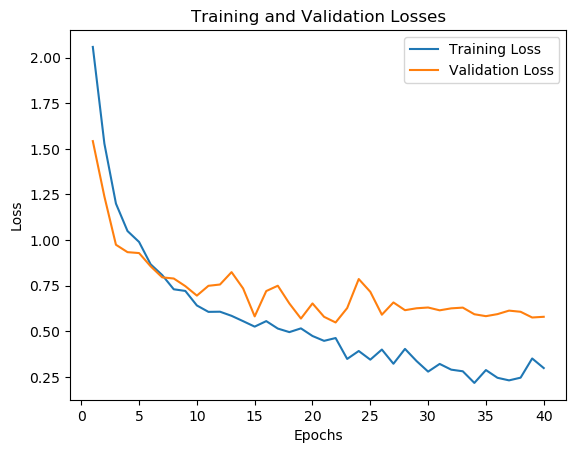

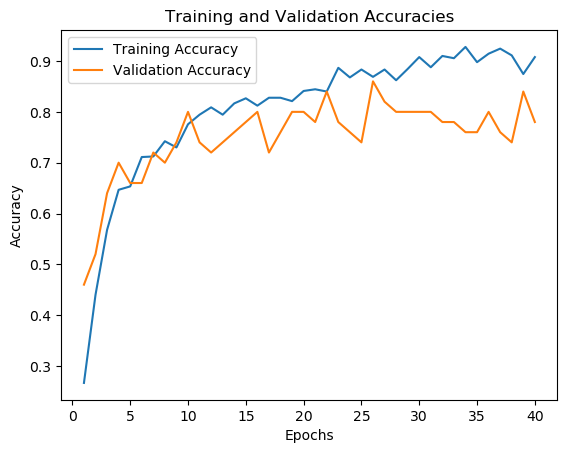

Test Loss: 1.2829, Test Accuracy: 66.0000


In [6]:
# Step 1 -> Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Step 2 -> Define configuration dictionary

# 69% test accuracy
# config = {
#     'input_size': 146,
#     'output_size': 10,
#     'hidden_layers': [146, 146, 146],
#     'batch_size': 16,
#     'n_epochs': 50,
#     'learning_rate': 0.001,
#     'dropout_rate': 0.3,  # Add dropout to reduce overfitting
#     'weight_decay': 0.0001  # Add L2 regularization
# }

#72% test accuracy
config = {
    'input_size': 146,
    'output_size': 10,
    'hidden_layers': [146, 146, 146],
    'batch_size': 25,
    'n_epochs': 40,
    'learning_rate': 0.002,
    'dropout_rate': 0.3,  # Add dropout to reduce overfitting
    'weight_decay': 0.0001  # Add L2 regularization
}

# Step 3 -> Define criterion - the loss
criterion = nn.CrossEntropyLoss()

# Step 4 -> Load the FashionMNIST data
#train_loader, val_loader, test_loader = load_dataset(config['batch_size'])
train_loader, val_loader, test_loader = load_dataset("../_03_data_gtzan_features_labels_pca.xlsx", config['batch_size'])

###################################################### DOING A LEARNING RATE SWEEP TO FIND THE BEST LEARNING RATE #################################################################################
# best_learning_rate = None
# best_val_loss = float('inf')
# results = {}

# Adjust the range of the sweep based on the graph displayed after the sweep
# learning_rates = np.logspace(-4, np.log10(9.8e-04), 10)
# for lr in learning_rates:
#     print(f"Testing learning rate: {lr:.1e}")

#     # Create model and optimizer
#     model = MLP(config['input_size'], config['output_size'], config['hidden_layers'])
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     # Train for 5 epochs
#     train_losses, train_accuracies, val_losses, val_accuracies = train(
#         model, criterion, optimizer, train_loader, val_loader, n_epochs=5, device=device
#     )

#     # Get the minimum validation loss for this learning rate
#     min_val_loss = min(val_losses)
#     results[lr] = min_val_loss

#     # Update the best learning rate based on validation loss
#     if min_val_loss < best_val_loss:
#         best_val_loss = min_val_loss
#         best_learning_rate = lr

# Print results
# print("\nLearning Rate Sweep Results:")
# print(f"{'Learning Rate':<15} {'Validation Loss':<20}")
# for lr, loss in results.items():
#     print(f"{lr:<15.1e} {loss:<20.4f}")

# print(f"\nBest Learning Rate: {best_learning_rate:.1e}, Best Validation Loss: {best_val_loss:.4f}")

# # Plot learning rate vs validation loss
# plt.figure(figsize=(10, 6))
# plt.semilogx(list(results.keys()), list(results.values()), marker='o')
# plt.xlabel("Learning Rate")
# plt.ylabel("Minimum Validation Loss")
# plt.title("Learning Rate Sweep")
# plt.grid(True)
# plt.show()
####################################################################################################################################################################################################

# Step 4 -> Create a model
model = MLP(config['input_size'], config['output_size'], config['hidden_layers'], config['dropout_rate'])

# Step 4 -> Send the model to the device
model.to(device)  # Send model to the chosen device

# Step 4 -> define the model optimizer - optimizes/updates the learnable weights in such a way that the loss is decreased
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Step 4 -> Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    tr_loader=train_loader,
    va_loader=val_loader,
    n_epochs=config['n_epochs'],
    device=device,
    scheduler=scheduler
)
####################################################################################################################################################################################

# Step 5 -> Plot training and validation losses
plt.figure()
plt.plot(range(1, config['n_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, config['n_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Step 5 -> Plot training and validation accuracies
plt.figure()
plt.plot(range(1, config['n_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, config['n_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

#####################################################################################################################################################################################

# Step 6: Evaluate the model on the test set (Inference)
test_loss, test_accuracy = test(model, criterion, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}")

#################################################################################################################################################3
# # Load stratified folds
# file_path = "../_03_data_gtzan_features_labels_pca.xlsx"
# batch_size = 64
# n_splits = 5
# folds = load_dataset_cv(file_path, batch_size, n_splits)

# # Initialize results
# fold_results = []

# print(fold_results)

# # Loop through folds
# for fold_idx, (tr_loader, va_loader) in enumerate(folds):
#     print(f"Fold {fold_idx + 1}/{n_splits}")

#     # Initialize model, criterion, and optimizer
#     input_size = tr_loader.dataset[0][0].shape[0]  # Feature size
#     output_size = 10 # Number of unique classes
#     hidden_layers = [16, 16]

#     model = MLP(input_size, output_size, hidden_layers)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#     # Train the model
#     train_losses, train_accuracies, val_losses, val_accuracies = train(
#         model, criterion, optimizer, tr_loader, va_loader, n_epochs=100, device="cpu"
#     )

#     # Store results for this fold
#     fold_results.append({
#         "train_losses": train_losses,
#         "train_accuracies": train_accuracies,
#         "val_losses": val_losses,
#         "val_accuracies": val_accuracies,
#     })

#     print(f"Fold {fold_idx + 1} - Final Val Accuracy: {val_accuracies[-1]:.4f}")

# # Aggregate Results
# avg_val_accuracy = sum([result["val_accuracies"][-1] for result in fold_results]) / n_splits
# print(f"Average Validation Accuracy Across Folds: {avg_val_accuracy:.4f}")

